<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/Style_Transfer/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
# import libraries
# essential libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K

# display images
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

#upload test images
from google.colab import files

In [2]:
# utility functions
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    imshow(image, title)

def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps = 1)
  
  return gif_path

def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

# Prepare the feature extractor



## get features

In [3]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """
  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

In [4]:
def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image)

  # get the outputs from the model that you created
  outputs = model(preprocessed_style_image)

  # Get just the style feature layers
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(layer) for layer in style_outputs]

  return gram_style_features

In [5]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the inception model
  outputs = model(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

## Define the loss

In [6]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """
  # Calculate the style loss
  style_loss = tf.reduce_mean(tf.square(features - targets))
  return style_loss

In [7]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss

In [8]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss
  
  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """
    
  # accumulate sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # accumulate sum of the content losses
  content_loss = tf.add_n([ get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the losses by multiplying by the weights and dividing by the number of layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss

  # return the total loss
  return total_loss

## Compute loss and gradients

In [9]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

    # add the total variation loss
    loss += var_weight*tf.image.total_variation(image)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image) 

  return gradients

In [10]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [11]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, content_weight, var_weight, optimizer) 
    
      print(".", end='')

    # display the current stylized image
    clear_output(wait = True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(display_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

# Prepare the model and generate the stylized image

1.   Run all the cells above this section
2.   Run **either** `InceptionV3 model` or `VGG19 model`
3.   Run the generate image below

*How to compare models*:

1.   Follow the normal steps above
2.   Run the other model
3.   un-comment the cell with the right adjusted weights and run to get a new prediction





## Inception V3 model

In [70]:
#@title Select Content Layer
content_layer = "conv2d_88" #@param ["conv2d_85","conv2d_87","conv2d_88","conv2d_91","conv2d_92","conv2d_93"] {type:"string"}
#@markdown ---
content_layers = [content_layer]


In [71]:
# choose the five style layers of interest
style_layers = ["conv2d","conv2d_1","conv2d_2","conv2d_3","conv2d_4"]

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [72]:
def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image
  
def inception_model(layer_names):
  """ Creates a inception model that returns a list of intermediate output values.
    args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  returns:
    A model that takes the regular inception v3 input and outputs just the content and style layers.
  
  """
  # Load InceptionV3 with the imagenet weights and **without** the fully-connected layer at the top of the network
  inception = tf.keras.applications.InceptionV3(include_top = False, weights = "imagenet")

  # Freeze the weights of the model's layers (make them not trainable)
  inception.trainable = False
  
  # Create a list of layer objects that are specified by layer_names
  output_layers = [inception.get_layer(name).output for name in layer_names]

  # Create the model that outputs the content and style layers
  model = tf.keras.Model(inputs = inception.input, outputs = output_layers)
    
  # return the model
  return model

K.clear_session()
model = inception_model(content_and_style_layers)

## VGG 19 model

In [89]:
#@title Select Style and Content Layers 
content_layer = "block5_conv2" #@param ["block4_conv1","block4_conv2","block4_conv3","block4_conv4","block5_conv1","block5_conv2","block5_conv3","block5_conv4"] {type:"string"}
#@markdown ---
content_layers = [content_layer]

In [90]:
# style layers of interest
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] 

# combine the two lists (put the style layers before the content layers)
content_and_style_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [91]:
def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image
  
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs = vgg.input, outputs = outputs)

  return model

K.clear_session()
model = vgg_model(content_and_style_layers)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# generate the new stylized image

### use example images

In [86]:
content_path = tf.keras.utils.get_file('content_image.jpg','https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg')
style_path = tf.keras.utils.get_file('style_image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

### upload your own images

In [ ]:
#content images
uploaded = files.upload()
for image in uploaded.keys():
    content_path = '/content/' + image

In [ ]:
#style images
uploaded = files.upload()
for image in uploaded.keys():
    style_path = '/content/' + image

### Generate images

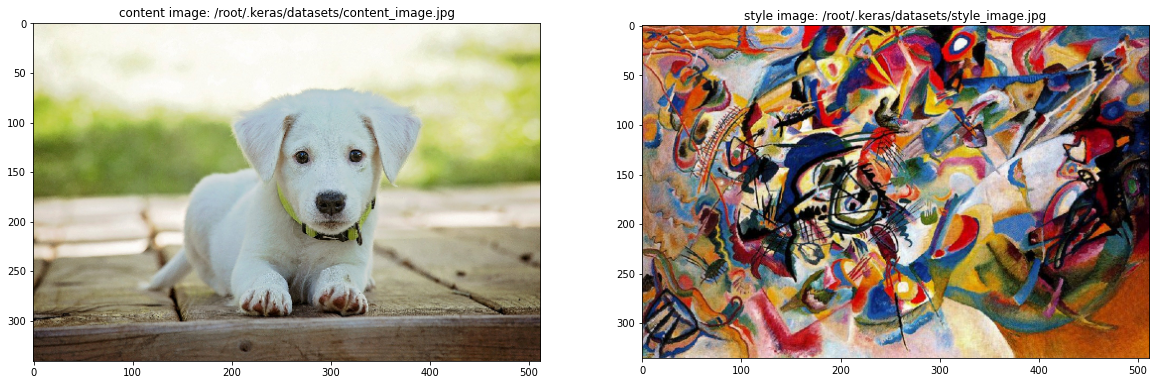

In [87]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles = ["content image: {}".format(content_path), "style image: {}".format(style_path)])

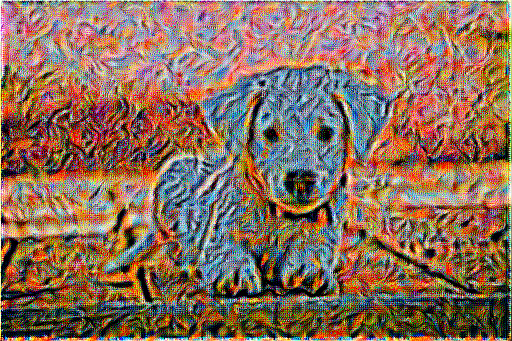

Train step: 100


In [88]:
# weight parameters (adjusted for InceptionV3)
style_weight =  1
content_weight = 1e-20
var_weight = 1e-5


# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 80.0, decay_steps = 50, decay_rate = 0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image = style_image, content_image = content_image, 
                                                    style_weight = style_weight, content_weight = content_weight,
                                                    var_weight = var_weight, optimizer = adam, epochs = 10, steps_per_epoch = 10)

In [40]:
# Create and Download GIF
GIF_PATH = 'style_transfer.gif'
gif_images = [np.array(image) for image in display_images]
gif_path = create_gif(GIF_PATH, gif_images)
files.download(GIF_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

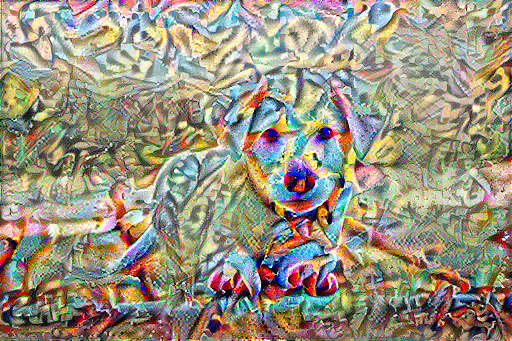

Train step: 100


In [92]:
# define style and content weight (adjusted for VGG19)
style_weight =  1e-4
content_weight = 1e-3
var_weight = 0


# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 30.0, decay_steps = 100, decay_rate = 0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image = style_image, content_image = content_image, 
                                                    style_weight = style_weight, content_weight = content_weight,
                                                    var_weight = 0, optimizer = adam, epochs = 10, steps_per_epoch = 10)